In [0]:
#dependancies
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import math

In [0]:
def prep(row):#Formats a line of csv to an array of floats shape=[304]
  y=row[-1]
  row=row[:-1]
  x=[]
  for i in row:
    try:
      for j in i:
        x.append(float(j))
    except:
      x.append(float(i))
  return x,y

def test(iteration):#runs a test with the hold-out set and prints the results
  batch_x=[]        #used in order to track progress during training
  batch_y=[]
  for i in hold_out:
    x,y=prep(i)
    batch_x.append(x)
    batch_y.append([y])
  error=math.sqrt(sess.run(tf.reduce_mean(cross_entropy),feed_dict={X:batch_x,Y:batch_y}))
  print("-"*15)
  print("iteration:",iteration)
  print("error:",error)
  print("-"*15)
  testing_log[0].append(iteration)#This log is used for graphs for training at the end
  testing_log[1].append(error)
  return error
def liniar1(x):#this is a function for the equivelent of no funciont in the layer_activation variable
  return x

In [0]:
train_data=pd.read_csv("train.csv")
train_data=train_data.drop(columns=["Id"])
print("columns:",len(train_data.columns)-1," + 1(x)")
raw_data=train_data.copy()
numbers=["MSSubClass","LotArea","OverallQual","OverallCond","YearBuilt","YearRemodAdd",
        "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","1stFlrSF","2ndFlrSF",
        "LowQualFinSF","GrLivArea","BsmtFullBath","BsmtHalfBath","BsmtHalfBath","FullBath",
        "HalfBath","BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces","GarageCars",
        "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch",
        "PoolArea","MiscVal","MoSold","YrSold","SalePrice"]
int_na=["GarageYrBlt","LotFrontage","MasVnrArea"]

for col in train_data.columns:
  new_col=[]
  
  if col in numbers:
    for i in train_data[col]:
      new_col.append(int(i))
  elif col in int_na:
    for i in train_data[col]:
      try:
        new_col.append(int(i))
      except:
        new_col.append(-1)   
  else:
    unis=train_data[col].unique()
    unilen=len(unis)
    for row in train_data[col]:
      pre_row=[]
      for i,v in enumerate(unis):
        if row==v:
          pre_row.append(1)
        else:
          pre_row.append(0)
      new_col.append(tuple(pre_row))
    
  train_data[col]=new_col

In [0]:
#SETUP HOLDOUT --OPTINAL
#if you do not want a hold-out do not run this box
n_hold_out=20
hold_out=[]
test_const=5#takes one of every 5 peices of training data for the holdout
for i in range(n_hold_out):
  hold_out.append(train_data.loc[i*test_const])
  train_data=train_data.drop([i*test_const])

x,y=prep(train_data.loc[1])
print(len(x))

In [0]:
#CONSTANTS
#Constants have been optimsed
n_input=304
n_out=1
n_layers=2#excludes input layer includes output layer
layer_number=[256,1]#number of neurons in each layer, excludes input layer includes output layer
layer_activation=[liniar1,liniar1,liniar1]#activation function for each layer
weight_decay_value=20
#outpus price

learning_rate=0.01
batch_size=train_data.count()[0]-n_hold_out#the whole dataset
#redefine batch_size in order to use mini-batches
batch_iterations=60
total_iterations=batch_size*batch_iterations

X=tf.placeholder("float",[None,n_input])
Y=tf.placeholder("float",[None,n_out])
dropout=tf.placeholder("float")#if 1 then dropout occurs ,if 0 no dropout occurs

test_occurance=1#in batch iterations

#output the hyperperameters of the network in a clear way
print("current structure:")
print("learning rate:\t\t"+str(learning_rate))
print("batch size:\t\t"+str(batch_size))
print("weight dacay value:\t"+str(weight_decay_value))
print("\tinput layer interger\t-304-")
for i in range(n_layers-1):
  print("\thidden layer float\t",end="")
  print("-"+str(layer_number[i])+"-\tactivation:"+str(layer_activation[i]))
print("\toutput layer float\t-1-\tactivation:"+str(layer_activation[-1]))

In [0]:
#import network --OPTIONAL
#can be sued to import a trained model
#Make sure the constants above are applicable for the imported model
#ONly accepts models exported from this program
import os
reW=[]
reB=[]
path=input("enter network path:")
layer_n=len(os.listdir(path+"/weights"))
for i in range(layer_n):
  reW.append([])
  with open(path+"/weights/l"+str(i)+".csv","r") as f:
    red=f.readlines()
  for j in red:
    reW[i].append([float(k) for k in j[:-1].split(",")])

with open(path+"/biases/biases.csv","r") as f:
  red=f.readlines()
  reB=[[float(j) for j in i[:-1].split(",")] for i in red]

weights=[]
biases=[]
layers=[]
for i in range(n_layers):
  biases.append(tf.Variable(reB[i]))
  weights.append(tf.Variable(reW[i]))
  if i==0:
    tf.add_to_collection("weight_decay",tf.nn.l2_loss(weights[-1])*weight_decay_value)
    layers.append(layer_activation[i](tf.math.add(tf.matmul(X,weights[i]),biases[i])))
  else:
    layers.append(layer_activation[i](tf.math.add(tf.matmul(layers[i-1],weights[i]),biases[i])))
out_layer=layers[-1]#take the final layer

cross_entropy=tf.reduce_mean(tf.square(tf.math.divide(tf.math.subtract(out_layer,Y),Y)))
weight_decay_loss = tf.get_collection('weight_decay')
total_loss=cross_entropy+weight_decay_loss
training_step=tf.train.AdamOptimizer(learning_rate).minimize(total_loss)

In [0]:
#make new networks --OPTIONAL
#initilises a new, untrained network using the hyperperameters above
weights=[]
biases=[]
layers=[]

for i in range(n_layers):
  biases.append(tf.Variable(tf.constant(0.1,shape=[layer_number[i]])))
  if i==0:#first layer
    weights.append(tf.Variable(#multiples random weights by a constant in order to prevent the network having too high weights at initilisation
        tf.math.scalar_mul(tf.math.sqrt(1/layer_number[i]**(i)),tf.truncated_normal([n_input,layer_number[i]],stddev=1))
                  ))
    tf.add_to_collection("weight_decay",tf.nn.l2_loss(weights[-1])*weight_decay_value)#sets up weight decay for L2 regulisation
    
    layers.append(layer_activation[i](tf.math.add(tf.matmul(X,weights[i]),biases[i])))
    
  else:
    weights.append(tf.Variable(
        tf.math.scalar_mul(tf.math.sqrt(1/layer_number[i]**(i)),tf.truncated_normal([layer_number[i-1],layer_number[i]],stddev=1))
                  ))
    layers.append(layer_activation[i](tf.math.add(tf.matmul(layers[i-1],weights[i]),biases[i])))

out_layer=layers[-1]#take the final layer

cross_entropy=tf.reduce_mean(tf.square(tf.math.divide(tf.math.subtract(out_layer,Y),Y)))#gets the mean of the square of the difference between prediction and correct answer
weight_decay_loss = tf.get_collection('weight_decay')
total_loss=cross_entropy+weight_decay_loss#weight_decal_loss is part of L2 regularization
training_step=tf.train.AdamOptimizer(learning_rate).minimize(total_loss)

In [0]:
testing_log=[[],[],[]]
init=tf.global_variables_initializer()
sess=tf.Session()
sess.run(init)

In [0]:
#Train the network
last=test(0)
place=0#excludes test data
for i in range(batch_iterations):
  batch_x=[]
  batch_y=[]
  for j in range(batch_size):
    while True:
      try:
        x,y=prep(train_data.loc[place])
      except:
        place+=1
        place%=train_data.count()[0]#loop trought the dataset
      finally:
        break
    place+=1
    place%=train_data.count()[0]
    batch_x.append(x)
    batch_y.append([y])
  results=sess.run([cross_entropy,training_step],feed_dict={X:batch_x,Y:batch_y})
  if (i+1)%test_occurance==0:
    k=math.sqrt(results[0])
    print("training error:",k)
    testing_log[2].append(k)
    p=test(i+1)
    if p-last>0:
      mod=0
      print("minimum hold-out:"+str(min(testing_log[1])))
      print("final hold-out:  "+str(testing_log[1][-1]))
      plt.plot(testing_log[0][mod:],testing_log[1][mod:],"r")#graphing error
      plt.plot(testing_log[0][mod:-1],testing_log[2][mod:],"b")#graphing training error
      plt.show()
      if input("Negitive progres, stop learning(y/n)").lower() == "y":
        break
      else:
        last=p
    else:
      last=p

minimum hold-out:0.4817691974783953
final hold-out:  0.48351294192101174


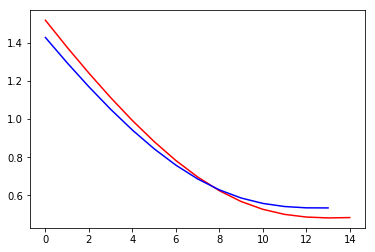

In [0]:
#Graph the training
#red is training error
#blue is hold-out error
mod=0
print("minimum hold-out:"+str(min(testing_log[1])))
print("final hold-out:  "+str(testing_log[1][-1]))
plt.plot(testing_log[0][mod:],testing_log[1][mod:],"r")#graphing error
plt.plot(testing_log[0][mod:-1],testing_log[2][mod:],"b")#graphing training error
plt.show()

In [0]:
#Test of the network on individual peices of the training data
print("number from 0-1459(inclusinve)")
pd.set_option('display.max_columns', None)
num=int(input("number:"))
if num>1459:
  print("too large")
elif num<0:
  print("too large")
else:
  try:
    test_row=train_data.loc[num]
  except:
    print("plesase chose a different number")
  else:
    if num%5==0:
      print("The network was not trained on this peice of data.")
    else:
      print("The network was trained on this peice of data.")
    #print(raw_data.loc[num:num])
    x,y=prep(test_row)
    outs=sess.run([cross_entropy,out_layer],feed_dict={X:[x],Y:[[y]]})
    print()
    print("Predicted value:\t $"+str(outs[1][0][0]))
    print("Actual value:\t\t $"+str(y))
    print("difference:\t\t $"+str(outs[1][0][0]-y))
    print("error:     \t\t"+str(abs(outs[1][0][0]-y)/y*100)+"%")
raw_data.loc[num:num]

In [0]:
#Export Network
final_weights=sess.run(weights)
final_baises=sess.run(biases)
import os

try:
  os.mkdir("network")
except:
  pass
try:
  os.mkdir("network//weights")
except:
  pass
try:
  os.mkdir("network//biases")
except:
  pass
for n,v in enumerate(final_weights):
  name="network//weights//l"+str(n)+".csv"
  final=""
  for i in v:
    for j in i:
      final+=str(j)+","
    final=final[:-1]
    final+="\n"
  with open(name,"w") as f:
    f.write(final)
fin=""
for i in final_baises:
  for j in i:
    fin+=str(j)+","
  fin=fin[:-1]
  fin+="\n"
with open("network//biases//biases.csv","w") as f:
  f.write(fin)
print("Network Exported")

Network Exported


In [0]:
#DOwnlaods the exported network for Google Colab
!zip -r /content/network.zip /content/network
from google.colab import files
files.download("/content/network.zip") 
print("network Downloaded")

  adding: content/network/ (stored 0%)
  adding: content/network/biases/ (stored 0%)
  adding: content/network/biases/biases.csv (deflated 62%)
  adding: content/network/weights/ (stored 0%)
  adding: content/network/weights/l1.csv (deflated 54%)
  adding: content/network/weights/l0.csv (deflated 57%)
network Downloaded
